In [31]:
import functions_ml as fml
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
import shap
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Train

In [32]:
results = pd.read_csv('datasets/instances_results.csv')
features = pd.read_csv('datasets/multi_plant_instance_features.csv')
dataset = fml.create_dataset(features, results)

In [33]:
dataset = fml.create_binary_target(dataset, tolerance=0.01/100)
dataset[['TARGET']].value_counts()

TARGET
GroupA    307
GroupB    291
Name: count, dtype: int64

In [34]:
X = dataset.drop(columns=['TARGET', 'instance'])
y = dataset['TARGET']

In [35]:
# Creating the Classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=2112)

# Create Stratified K-Fold for cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=2112)

# Evaluate model using cross-validation
f1_scorer = make_scorer(f1_score, pos_label='GroupA')
f1_scores = cross_val_score(classifier, X, y, cv=cv, scoring=f1_scorer)
print("Cross-Validated F1 Scores:", f1_scores)
print("Mean F1 Score:", f"{np.mean(f1_scores):.4f}")

Cross-Validated F1 Scores: [0.76363636 0.81967213 0.89230769 0.89230769 0.87096774 0.82539683
 0.8        0.75757576 0.77419355 0.86153846]
Mean F1 Score: 0.8258


In [36]:
# Optional: Cross-validation predictions for confusion matrix and other metrics
predictions = cross_val_predict(classifier, X, y, cv=cv)

# Evaluate metrics based on cross-validated predictions
accuracy = accuracy_score(y, predictions)
precision = precision_score(y, predictions, pos_label='GroupA')
recall = recall_score(y, predictions, pos_label='GroupA')
f1 = f1_score(y, predictions, pos_label='GroupA')
matrix = confusion_matrix(y, predictions)

# Output performance metrics
print(f"Cross-Validated Accuracy: {accuracy:.4f}")
print(f"Cross-Validated Precision: {precision:.4f}")
print(f"Cross-Validated Recall: {recall:.4f}")
print(f"Cross-Validated F1 Score: {f1:.4f}")
print("Confusion Matrix:\n", matrix)

Cross-Validated Accuracy: 0.8177
Cross-Validated Precision: 0.8075
Cross-Validated Recall: 0.8469
Cross-Validated F1 Score: 0.8267
Confusion Matrix:
 [[260  47]
 [ 62 229]]


# Explain

In [22]:
# Train on all data
classifier.fit(X, y)

RandomForestClassifier(random_state=2112)

## Permutation importance

                      Feature  Importance
36             avg_setup_cost    0.010656
59            max_utilization    0.008108
35           total_setup_cost    0.005536
37             std_setup_cost    0.004882
57            min_utilization    0.003578
10               std_capacity    0.002607
58            avg_utilization    0.002606
45   skew_transportation_cost    0.002279
12              kurt_capacity    0.001958
60           skew_utilization    0.001955
61           kurt_utilization    0.001626
41  total_transportation_cost    0.001306
11              skew_capacity    0.001305
43    avg_transportation_cost    0.001302
46   kurt_transportation_cost    0.001302
25            kurt_setup_time    0.000979
23             avg_setup_time    0.000979
44    std_transportation_cost    0.000653
30        std_production_cost    0.000653
31       kurt_production_cost    0.000653


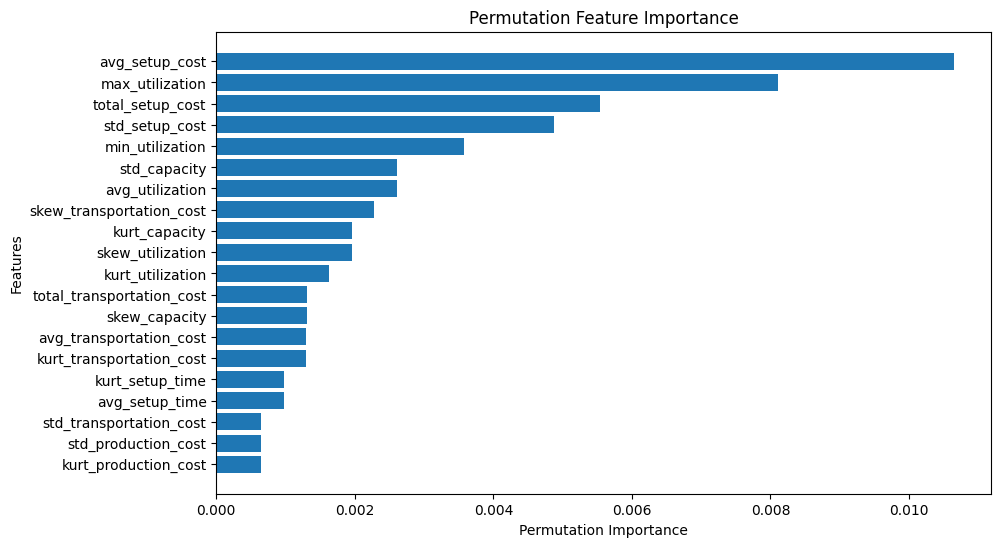

In [23]:
# Compute permutation importance
f1_scorer = make_scorer(f1_score, pos_label='GroupA')
perm_importance = permutation_importance(classifier, X, y, scoring=f1_scorer, random_state=2112)

# Create a DataFrame for readability
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

importances = importances.head(20)
print(importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.title("Permutation Feature Importance")
plt.show()

## Random forest features

In [24]:
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)
importances.head(20)

,Feature,Importance
35,total_setup_cost,0.074218
12,kurt_capacity,0.058663
36,avg_setup_cost,0.053683
41,total_transportation_cost,0.050881
37,std_setup_cost,0.050050
46,kurt_transportation_cost,0.043096
45,skew_transportation_cost,0.042486
43,avg_transportation_cost,0.040706
48,iqr_transportation_cost,0.039805
59,max_utilization,0.036044


                      Feature  Importance
35           total_setup_cost    0.074218
12              kurt_capacity    0.058663
36             avg_setup_cost    0.053683
41  total_transportation_cost    0.050881
37             std_setup_cost    0.050050
46   kurt_transportation_cost    0.043096
45   skew_transportation_cost    0.042486
43    avg_transportation_cost    0.040706
48    iqr_transportation_cost    0.039805
59            max_utilization    0.036044
57            min_utilization    0.034673
10               std_capacity    0.034323
1                  num_plants    0.031759
13                cv_capacity    0.030509
39            kurt_setup_cost    0.028620
58            avg_utilization    0.023722
60           skew_utilization    0.023432
61           kurt_utilization    0.023193
40              cv_setup_cost    0.022881
3                 binary_vars    0.020968


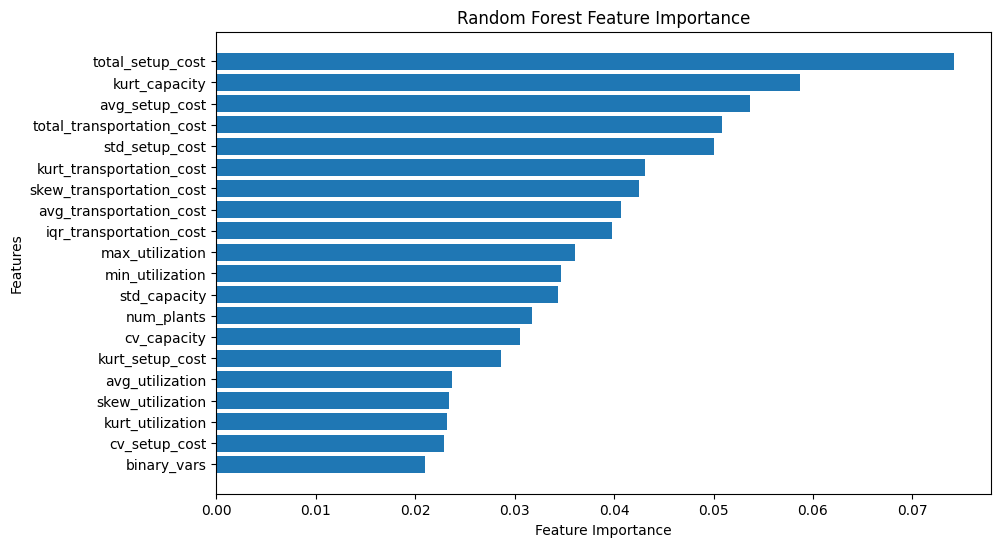

In [25]:
# Extract feature importances
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

importances = importances.head(20)
print(importances)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.show()

## Partial dependence plots

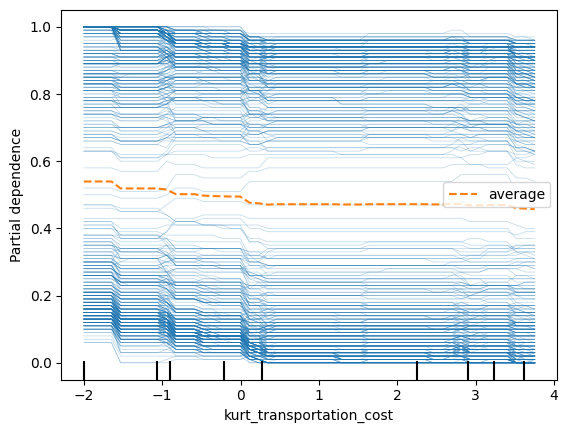

In [26]:
PartialDependenceDisplay.from_estimator(classifier, X, features=['kurt_transportation_cost'], kind="both", grid_resolution=50)
plt.show()

## SHAP

In [27]:
# Initialize SHAP explainer for Tree-based models
explainer = shap.TreeExplainer(classifier)

# Compute SHAP values for all classes
shap_values = explainer.shap_values(X)

# Extract SHAP values for the positive class ('GroupA')
shap_values_binary = shap_values[:, :, 0]  # Focus on class 1

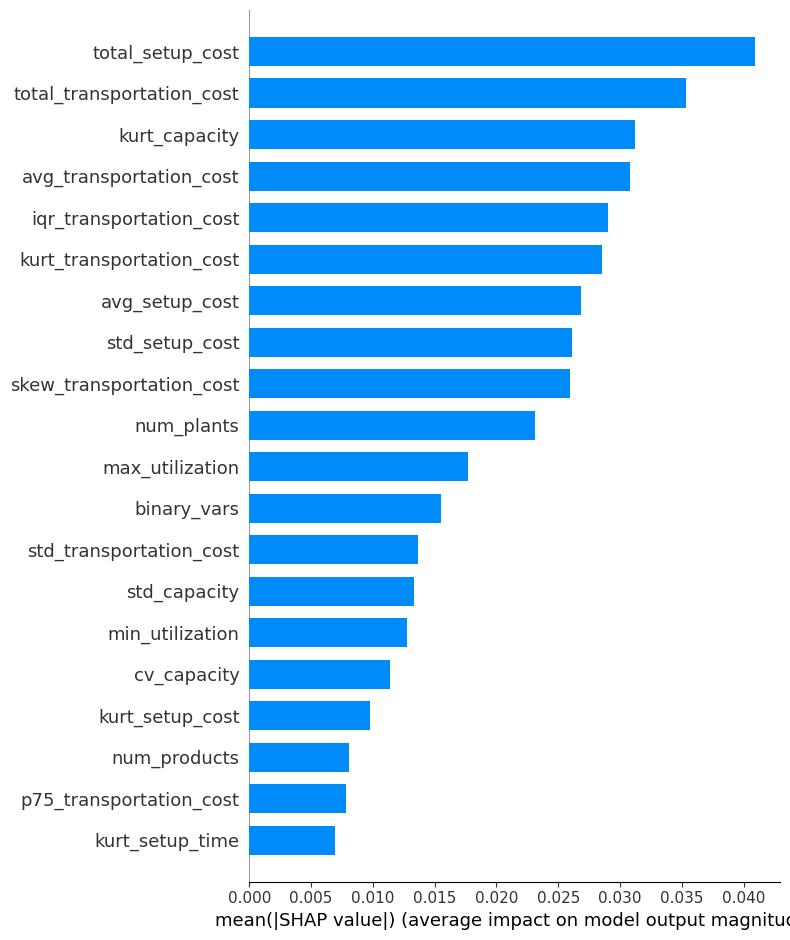

In [28]:
# 1. Summary Plot (Bar Chart for Global Feature Importance)
shap.summary_plot(shap_values_binary, X, plot_type="bar")

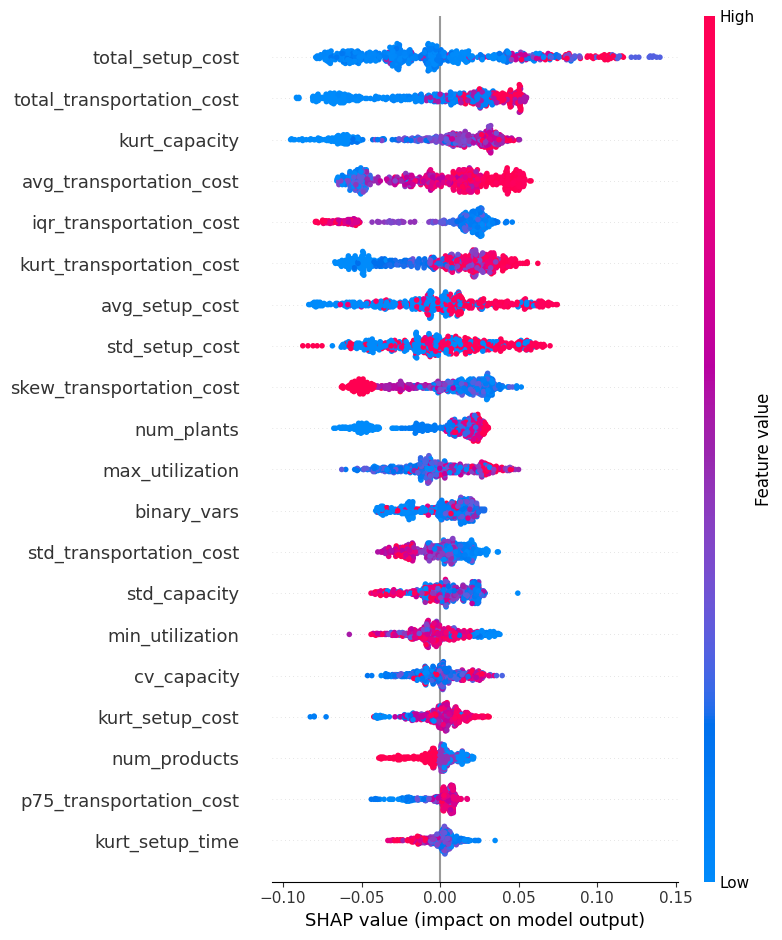

In [29]:
# 2. Beeswarm Plot (Detailed Feature Impact Across Predictions)
shap.summary_plot(shap_values_binary, X)

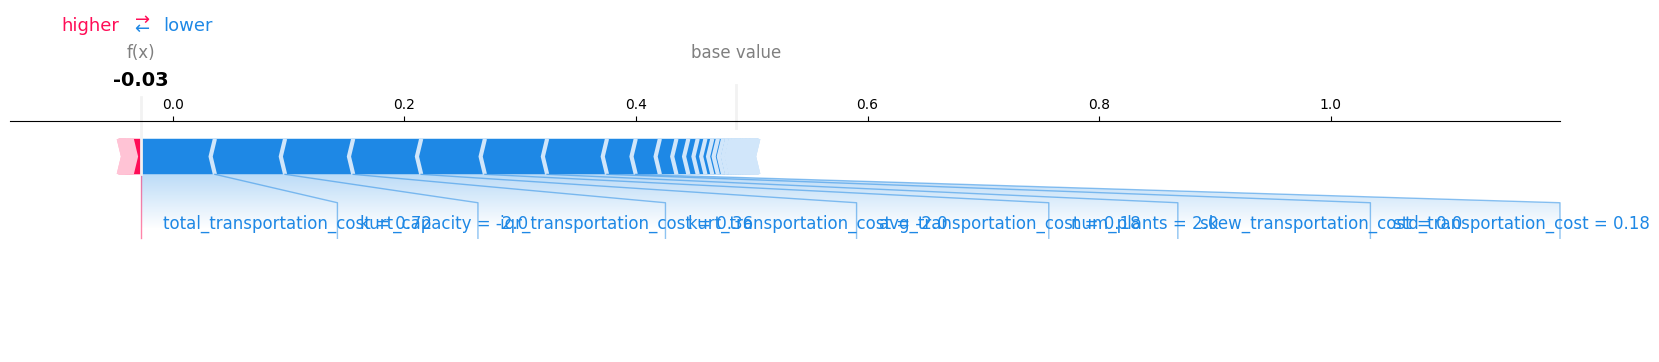

In [30]:
# 3. Single Instance Explanation (Force Plot)
sample_index = 0  # Example: First instance
shap.force_plot(
    explainer.expected_value[1], shap_values_binary[sample_index, :], X.iloc[sample_index, :],
    matplotlib=True
)